# AVALARA CODING ASSIGNMENT - SENIOR ML ENGINEER

## Problem Statement

Avalara is a tax technology company that helps businesses manage complicated tax
compliance obligations imposed by their state, local, and other tax authorities throughout the
world. Each year, we process billions of indirect tax transactions for more than 25,000
customers.

Figuring out the exact tax for what they sell is a big hurdle for many businesses. To accurately
calculate the sales tax for a product, businesses have to classify the product, which is where
product classification comes in.

One of the first steps in classification is to determine whether the transaction was for a product /
service before classifying it into further granular categories. Your challenge is to build a top level

binary classifier to determine whether the given listing falls under the service(S) or product/non-
service(R) category.

## Data Description (both train and test)

Training data contains ~1.2 million records and has the following fields: 1. title 2. description -
Additional high level description of the item (Important : This may or may not always be
available in the test set) 3. category - The class to which the item belongs. Values can be either
S or R. The problem requires you to use title, description and predict the output category.
Datasets are present under the ml-assignment folder here: ml-assignment
(https://drive.google.com/drive/folders/12FSbAwNDZY695QHs4mIVGiP92tz-533B) where
training.csv is the training dataset and test1.csv is the test dataset.

## Evaluation Criteria

1. You should submit a file “submissions.tsv” that contains an additional column with the
predictions from your model.
2. The submission should also contain a Jupyter Notebook or Python/Scala/Julia Script
with the model(s) actually built. It should contain in detail the following
o All the Exploratory data analysis done on the dataset.
o Preprocessing logic and rationale for them if any.
o Model Training code.
o Model Prediction code.
o A Readme that can help us replicate the submission score.
o Plot confusion matrix
o Write up about the decisions you made with regards to model, features etc

## Solution

### Importing necessary packages


In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn import feature_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import manifold
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.utils.vis_utils import plot_model
from tensorflow.random import set_seed

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jks_1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jks_1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Load, Preprocessing and EDA

In [2]:
training_data = pd.read_csv('./data/training.tsv', sep='\t')



In [3]:
testing_data = pd.read_csv('./data/test1.csv', sep='\t')

testing_data.head()

,title,description,category
0,Myo-Aid,Human Nutritional Supplements/Vitamin Supplements,R
1,ASM Community Advertising,Online adverstisemtn on one of ASM electronic ...,S
2,Application Services,"Application Services include access to, and us...",S
3,Carpet Repairs,NaN,S
4,Bio-Sponge®,Human Nutritional Supplements/Vitamin Supplements,R


#### THE DATASET

The dataset is comprised of three columns

1. `title` - Text - Predictor
Title of the item/offering.

2. `description` - Text - Predictor
Description of the item/offering.

3. `category` - Character - Label
Labeling denoting the item type- service(S) or product/non-service(R).

In [4]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 3 columns):
title          1199998 non-null object
description    1200000 non-null object
category       1200000 non-null object
dtypes: object(3)
memory usage: 27.5+ MB


#### NULLS

`title` has 2 null values, but the other fields are fine. However, as per the problem statement `description` can be missing in the test set.

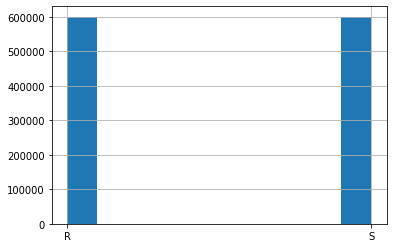

In [5]:
training_data.category.hist()

#### LABEL DISTRIBUTION

We can see that the label field is binary and that its values are distributed fairly evenly. Owing to this and with the large number of training samples we have we can avoid stratified sampling.

In [6]:
training_data.describe().loc['unique']

title          1195435
description       1295
category             2
Name: unique, dtype: object

#### TEXT PREPROCESSING

Looking at the unique values for `title` and `description`, we can safely make the assumption that the values for `description` are standardized and likely selected from a dropdown or something similar while `title` values were likely manually entered.

One might think that this indicates less predictive power from `title` compared to `description`. However, since we leverage feature selection techniques including a chi-squared test, word embeddings and other techniques like convolution it is important we use `title` in conjunction with `description`. The aforementioned techniques ensure that only statistically significant tokens and n-grams are selected/learned from when training the model.

We preprocess the text by removing punctuation, lowercasing, lemmatizing and removing digits (making an exception for 'B2C').

In [7]:
lemmatizer = WordNetLemmatizer()

def preproc(df):
    df['combined'] = df['title'].fillna('') + df['description'].fillna('').apply(lambda x: ' '+x)
    df['combined'] = df['combined'].str.replace('[^\w\s]',' ').apply(lambda x: x.replace('_', ' ').split()).apply(lambda x: [lemmatizer.lemmatize(y.lower()) for y in x]).apply(lambda x: " ".join([''.join((x for x in s if (s!='B2C' and not x.isdigit()))) for s in x if not s.isnumeric()]))
    return df
    
training_data = preproc(training_data)

training_data.head()

,title,description,category,combined
0,ZicZac // Black + Red (Euro: 44),Clothing & related products (B2C) - Shoes and ...,R,ziczac black red euro clothing related product...
1,9X9 RESISTA/484938,Publishing/Printing - Printing Services,S,x resista publishing printing printing service
2,Halle Pant - Short Inseam 013049561D0010001_ 02,Clothing & related products (B2C) - General,R,halle pant short inseam d clothing related pro...
3,Harry Houser Travel Expenses - Meals,Security - personnel,S,harry houser travel expense meal security pers...
4,Tee Time: 740078609 : Greens Fee - Composite,Admissions - Green Fees for Privately Owned Go...,R,tee time green fee composite admission green f...


In [8]:
testing_data = preproc(testing_data)

testing_data.head()

,title,description,category,combined
0,Myo-Aid,Human Nutritional Supplements/Vitamin Supplements,R,myo aid human nutritional supplement vitamin s...
1,ASM Community Advertising,Online adverstisemtn on one of ASM electronic ...,S,asm community advertising online adverstisemtn...
2,Application Services,"Application Services include access to, and us...",S,application service application service includ...
3,Carpet Repairs,NaN,S,carpet repair
4,Bio-Sponge®,Human Nutritional Supplements/Vitamin Supplements,R,bio sponge human nutritional supplement vitami...


### What's next?

Our dataset is cleaned and ready. We are going to leverage a variety of machine learning and deep learning algorithms to build models capable of accurately predicting the item category. For each of these approaches we use slightly different data preparation techniques.





### 1. Traditional Machine Learning Models

We're going to prep our dataset using the Bag-of-words model where the combined text of the title and description is converted to a vector of 0s and 1s that denote the presence and absence of words from the total observed vocabulary. In the first iteration we are going to try out a variety of baseline models on a random sample of the training data and evaluate performance on the test set. We will then select the best performing model, train it on the full training set and tune some hyperparameters to improve performance.

In [9]:
MAX_FEATURES = 2000
#Number of max features for count vectorizer

def get_cvec(): 
    return CountVectorizer(ngram_range = (1, 3), 
                       max_features=MAX_FEATURES, 
                       stop_words = 'english', 
                       binary=True)

def get_cross_val_score(clf, X, y):
    cvec = get_cvec()
    pipe = Pipeline([('vect', cvec), ('clf', clf)])
    scores =  cross_val_score(pipe, X, y, cv=3, verbose=1, n_jobs=30)
    return scores


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    sns.set(font_scale=1.2)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.title('precision vs recall')
    
    
def plot_roc_curve(fpr, tpr):
    sns.set(font_scale=1.2)
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('roc curve')

def plot_conf_matrix(cmap, classes):
    sns.set(font_scale=1.2)
    plot_confusion_matrix(conf_mat = cmap,
                                       class_names = classes,
                                       show_absolute = True,
                                       show_normed = False,
                                       colorbar = True, 
                                       figsize=(8, 8))
    plt.title('confusion matrix')
    plt.ylim(-0.5, 1.5)
    plt.show()

def clf_performance(clf, clf_name, X, y, X_test, y_test):
    classes = ['R', 'S']
    print("EVALUATING PERFORMANCE FOR "+clf_name)
    

    cvec = CountVectorizer(ngram_range = (1, 3), 
                       max_features=MAX_FEATURES, 
                       stop_words = 'english', 
                       binary=True)
    pipe = Pipeline([('vect', cvec), ('clf', clf)])
    
    pipe.fit(X, y)
    
    y_pred = pipe.predict(X_test)
    
    print(classification_report(y_test, y_pred, target_names=classes))
    
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 2, 1)
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    ax = fig.add_subplot(1, 2, 2)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    plot_roc_curve(fpr, tpr)
    cmap = confusion_matrix(y_test, y_pred)
    
    plot_conf_matrix(cmap, classes)
    

In [10]:
sample = training_data.sample(frac=0.5, random_state=42)
#Sampling 50% of the training data

X = sample['combined']
y = sample['category'].apply(lambda x: 0 if x=='R' else 1)

X_test = testing_data['combined']
y_test = testing_data['category'].apply(lambda x: 0 if x=='R' else 1)


EVALUATING PERFORMANCE FOR Random Forest Classifier
              precision    recall  f1-score   support

           R       0.65      0.89      0.75        35
           S       0.91      0.70      0.79        57

    accuracy                           0.77        92
   macro avg       0.78      0.79      0.77        92
weighted avg       0.81      0.77      0.77        92



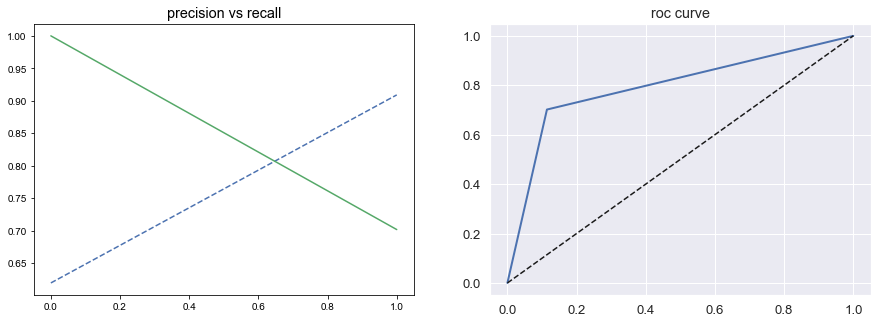

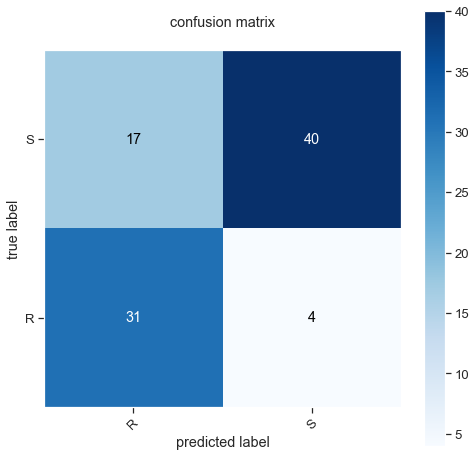

In [11]:
clf_performance(RandomForestClassifier(), 'Random Forest Classifier', X, y, X_test, y_test)

EVALUATING PERFORMANCE FOR Multinomial Naive Bayes
              precision    recall  f1-score   support

           R       0.86      0.91      0.89        35
           S       0.95      0.91      0.93        57

    accuracy                           0.91        92
   macro avg       0.91      0.91      0.91        92
weighted avg       0.91      0.91      0.91        92



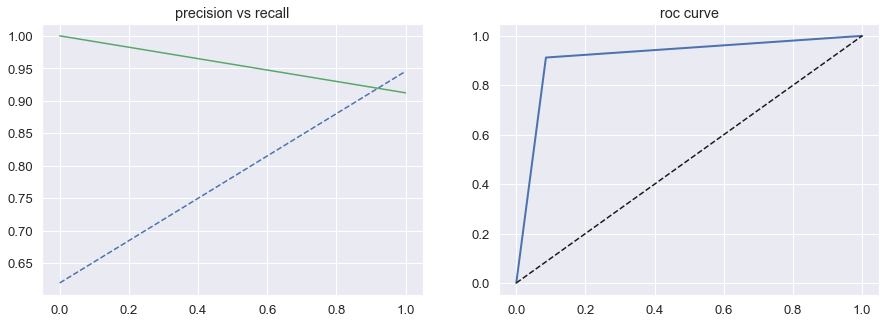

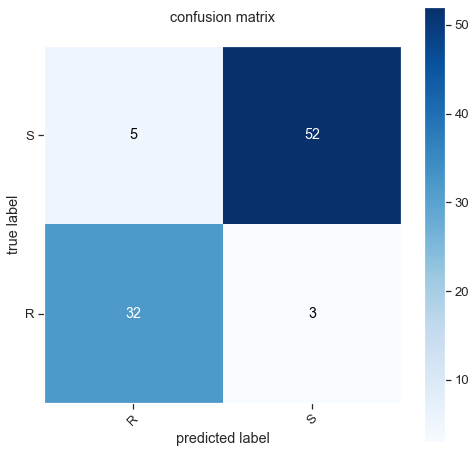

In [12]:
clf_performance(MultinomialNB(), 'Multinomial Naive Bayes', X, y, X_test, y_test)

EVALUATING PERFORMANCE FOR Linear SVC
              precision    recall  f1-score   support

           R       0.62      0.89      0.73        35
           S       0.90      0.67      0.77        57

    accuracy                           0.75        92
   macro avg       0.76      0.78      0.75        92
weighted avg       0.80      0.75      0.75        92



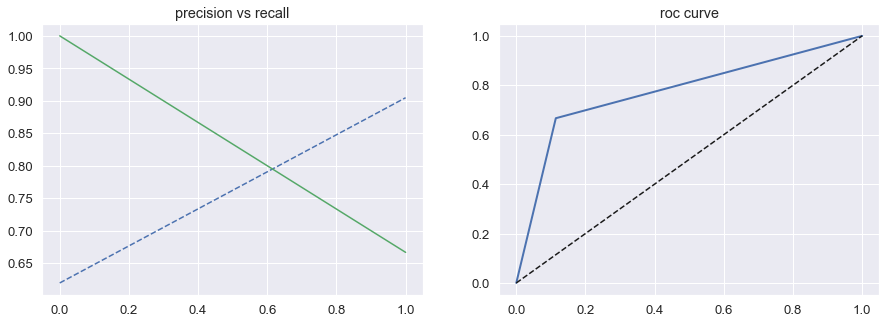

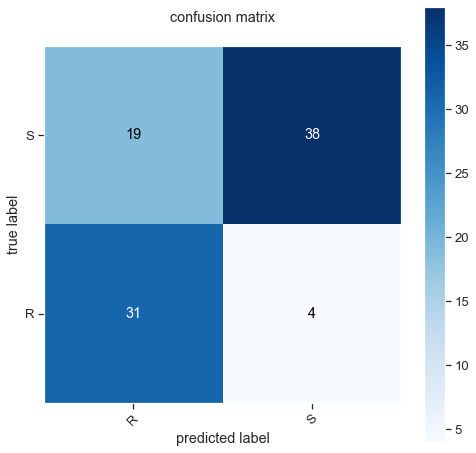

In [13]:
clf_performance(LinearSVC(), 'Linear SVC', X, y, X_test, y_test)

EVALUATING PERFORMANCE FOR LogisticRegression
              precision    recall  f1-score   support

           R       0.62      0.89      0.73        35
           S       0.90      0.67      0.77        57

    accuracy                           0.75        92
   macro avg       0.76      0.78      0.75        92
weighted avg       0.80      0.75      0.75        92



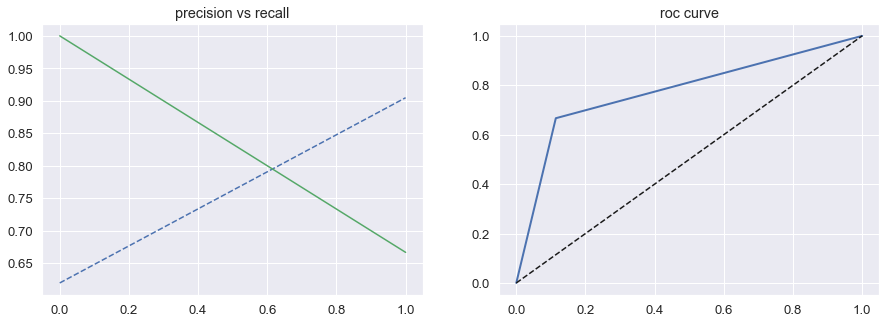

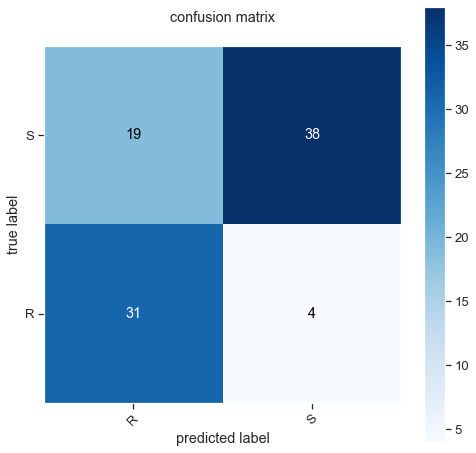

In [14]:
clf_performance(LinearSVC(), 'LogisticRegression', X, y, X_test, y_test)

From the above seen metrics, we can see the MultinomialNB does relatively well in comparison to the others.

In [15]:
#Taking all available training data
X = training_data['combined']
y = training_data['category'].apply(lambda x: 0 if x=='R' else 1)


We can use GridSearch to tune hyperparameter values to attain optimal performance using the code below.

<code>from sklearn.model_selection import GridSearchCV

#Vectorizing input text
cvec = get_cvec()
X_prep = cvec.fit_transform(X).toarray()
X_test_prep = cvec.transform(X_test).toarray()

grid_params = {
  'alpha': np.linspace(0.5, 1.5, 8),
  'fit_prior': [True, False],  
}
clf = GridSearchCV(MultinomialNB(), grid_params, n_jobs=3, cv=3)
clf.fit(X_prep, y)

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)
</code>


Note: As the final submission is made later using a different approach I have opted not to tune for hyper parameters in order to minimize training time for this exercise.


### 2. Convolutional Neural Network

Neural networks comprised of embedding layers and convolution layers have seen application and good performance in Text Classification problems. Yoon Kim disccusses in his paper Convolutional Neural Networks for Sentence Classification (https://arxiv.org/abs/1408.5882) how, at the time, CNNs improved on state-of-the-art performance on 4 of 7 tasks. The word embedding matrix for a sentence can resemble an image tensor thus owing to convolution layers being good an observing similar patterns in similar sentences. We see how a simple CNN with a single 1-D convolution layer performs.

In [16]:
#Using keras preprocessing to preprocess input as padded vectors, 
#padded to the highest word length observed in the training data

def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 

def max_length(lines):
    return max([len(s.split()) for s in lines])
 

def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded
 
#Note the use of regularization to prevent overfitting the training data
def define_model(length, vocab_size):
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 50)(inputs1) 
    conv1 = Conv1D(filters=16, kernel_size=6, activation='relu', 
                   kernel_regularizer=regularizers.l1_l2(l1=1e-5, 
                                                         l2=1e-4),
                   bias_regularizer=regularizers.l2(1e-4))(embedding1)
    drop1 = Dropout(0.6)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    dense1 = Dense(10, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, 
                                                                                l2=1e-4),
                   bias_regularizer=regularizers.l2(1e-4))(flat1)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=inputs1, outputs=outputs)

    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

    print(model.summary())
    return model

    
tokenizer = create_tokenizer(X)

length = max_length(X)

vocab_size = len(tokenizer.word_index) + 1

print(f'Max token set length: {str(length)}')
print(f'Vocabulary size: {str(vocab_size)}')

Max token set length: 430
Vocabulary size: 263210


In [17]:
X_enc = encode_text(tokenizer, X, length)
X_test_enc = encode_text(tokenizer, X_test, length)

In [18]:
model = define_model(length, vocab_size)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 430)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 430, 50)           13160500  
_________________________________________________________________
conv1d (Conv1D)              (None, 425, 16)           4816      
_________________________________________________________________
dropout (Dropout)            (None, 425, 16)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 212, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3392)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                33930 

In [19]:
set_seed(42)

history = model.fit(X_enc, y, epochs=5, batch_size=512, validation_data = (X_test_enc, y_test)) 

Epoch 1/5
2344/2344 [==============================] - 390s 159ms/step - loss: 0.0756 - accuracy: 0.9732 - val_loss: 0.3186 - val_accuracy: 0.9022
Epoch 2/5
2344/2344 [==============================] - 373s 159ms/step - loss: 0.0044 - accuracy: 0.9997 - val_loss: 0.2203 - val_accuracy: 0.9565
Epoch 3/5
2344/2344 [==============================] - 374s 160ms/step - loss: 0.0030 - accuracy: 0.9999 - val_loss: 0.2734 - val_accuracy: 0.9457
Epoch 4/5
2344/2344 [==============================] - 375s 160ms/step - loss: 0.0023 - accuracy: 0.9999 - val_loss: 0.3152 - val_accuracy: 0.9239
Epoch 5/5
2344/2344 [==============================] - 373s 159ms/step - loss: 0.0019 - accuracy: 0.9999 - val_loss: 0.2282 - val_accuracy: 0.9457


In [20]:
model.evaluate(X_test_enc, y_test)

3/3 [==============================] - 0s 8ms/step - loss: 0.2282 - accuracy: 0.9457


[0.2281973659992218, 0.945652186870575]

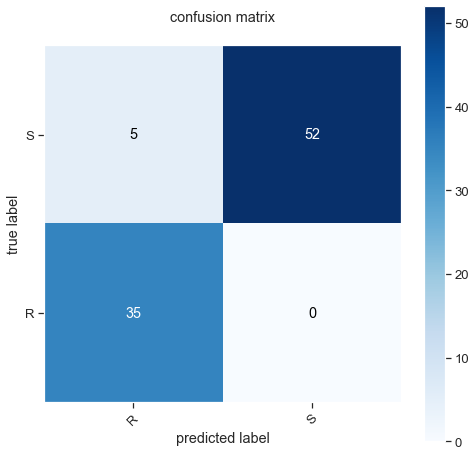

In [21]:
 
y_pred = [1 if x>0.5 else 0 for x in model.predict(X_test_enc)]
cmap = confusion_matrix(y_test, y_pred)
plot_conf_matrix(cmap, ['R', 'S'])


### 3. Wide Convolutional Neural Network

Continuing over from part 2, we try to enhance performance by utilizing a multi-channel CNN each with a different kernel size.

As this makes the model much more complex we must increase regularization to keep overfitting in check.

We also utilize some handy keras features to add some stocastic sampling to the fitting process as well as to stop the training process once test accuracy doesn't improve for a few epochs.

In [22]:
def define_wide_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 30)(inputs1)
    conv1 = Conv1D(filters=8, kernel_size=4, activation='relu', 
                   kernel_regularizer=regularizers.l1_l2(l1=1e-3, 
                                                         l2=1e-2),
                   bias_regularizer=regularizers.l2(1e-2))(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 30)(inputs2)
    conv2 = Conv1D(filters=8, kernel_size=6, activation='relu', 
                   kernel_regularizer=regularizers.l1_l2(l1=1e-3, 
                                                         l2=1e-2),
                   bias_regularizer=regularizers.l2(1e-2))(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 30)(inputs3)
    conv3 = Conv1D(filters=8, kernel_size=8, activation='relu', 
                   kernel_regularizer=regularizers.l1_l2(l1=1e-3, 
                                                         l2=1e-2),
                   bias_regularizer=regularizers.l2(1e-2))(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])

    dense1 = Dense(10, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-3, 
                                                                                l2=1e-2),
                   bias_regularizer=regularizers.l2(1e-2))(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    
    
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

    print(model.summary())
    
    return model
 

    

model = define_wide_model(length, vocab_size)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 430)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 430)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 430)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 430, 30)      7896300     input_2[0][0]                    
____________________________________________________________________________________________

In [23]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpoint = ModelCheckpoint('best_wide_cnn_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)
#These callbacks ensure that excess training is not carried out past 10 epochs while saving the best performing model

In [24]:
set_seed(42)
history = model.fit([X_enc, X_enc, X_enc], y, epochs=50, batch_size=256, 
                    validation_data = ([X_test_enc, X_test_enc, X_test_enc], y_test), 
                    shuffle=True, steps_per_epoch=100, 
                    callbacks=[earlystopping, checkpoint])

Epoch 1/50
100/100 [==============================] - 23s 203ms/step - loss: 1.5062 - accuracy: 0.7149 - val_loss: 0.6193 - val_accuracy: 0.8587
Epoch 2/50
100/100 [==============================] - 20s 197ms/step - loss: 0.2901 - accuracy: 0.9885 - val_loss: 0.4262 - val_accuracy: 0.8804
Epoch 3/50
100/100 [==============================] - 20s 200ms/step - loss: 0.1710 - accuracy: 0.9927 - val_loss: 0.3668 - val_accuracy: 0.8804
Epoch 4/50
100/100 [==============================] - 20s 198ms/step - loss: 0.1367 - accuracy: 0.9943 - val_loss: 0.3383 - val_accuracy: 0.8804
Epoch 5/50
100/100 [==============================] - 20s 198ms/step - loss: 0.1166 - accuracy: 0.9964 - val_loss: 0.3346 - val_accuracy: 0.8587
Epoch 6/50
100/100 [==============================] - 20s 199ms/step - loss: 0.1068 - accuracy: 0.9958 - val_loss: 0.2981 - val_accuracy: 0.9022
Epoch 7/50
100/100 [==============================] - 20s 198ms/step - loss: 0.0947 - accuracy: 0.9953 - val_loss: 0.2883 - val_ac

In [25]:
model.evaluate([X_test_enc, X_test_enc, X_test_enc], y_test)

3/3 [==============================] - 0s 12ms/step - loss: 0.2345 - accuracy: 0.9130


[0.2345227748155594, 0.9130434989929199]

### FINAL SUBMISSION

In [26]:
best = keras.models.load_model('best_wide_cnn_model.h5')

In [27]:
best.evaluate([X_test_enc, X_test_enc, X_test_enc], y_test)

3/3 [==============================] - 0s 14ms/step - loss: 0.2429 - accuracy: 0.9674


[0.24292859435081482, 0.967391312122345]

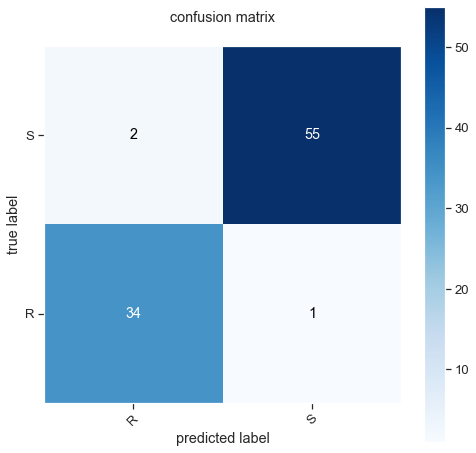

In [28]:
y_pred = [1 if x>0.5 else 0 for x in best.predict([X_test_enc, X_test_enc, X_test_enc])]
cmap = confusion_matrix(y_test, y_pred)
plot_conf_matrix(cmap, ['R', 'S'])

In [29]:
testing_data['predictions'] = y_pred
testing_data['predictions'] = testing_data['predictions'].apply(lambda x: 'R' if x==0 else 'S')

testing_data.head()

,title,description,category,combined,predictions
0,Myo-Aid,Human Nutritional Supplements/Vitamin Supplements,R,myo aid human nutritional supplement vitamin s...,R
1,ASM Community Advertising,Online adverstisemtn on one of ASM electronic ...,S,asm community advertising online adverstisemtn...,S
2,Application Services,"Application Services include access to, and us...",S,application service application service includ...,S
3,Carpet Repairs,NaN,S,carpet repair,S
4,Bio-Sponge®,Human Nutritional Supplements/Vitamin Supplements,R,bio sponge human nutritional supplement vitami...,R


In [30]:
testing_data[['title', 'description', 'category', 'predictions']].to_csv('./data/submissions.tsv', sep='\t', index=False)